In [101]:
# 共通で利用するライブラリ
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score, confusion_matrix
from sklearn.model_selection import train_test_split
from dateutil.relativedelta import relativedelta
import glob
import os
import datetime
import pickle
from natsort import natsorted
from IPython.display import display, clear_output
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import warnings

# warnings.filterwarnings('ignore')
np.set_printoptions(suppress=True, precision=3)
pd.options.display.float_format = "{:.4f}".format
pd.set_option("display.max_columns", None)
plt.style.use("seaborn")
plt.rcParams["font.size"] = 14
plt.rcParams["font.family"] = "IPAexGothic"
%matplotlib inline
%load_ext autoreload

# 追加するライブラリ
import seaborn as sns
from ipywidgets import Select, SelectMultiple


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Ch.10 機械学習システムのダッシュボードを作成する

- 店舗分析用のダッシュボードの追加
- 機械学習モデルの評価検証用ダッシュボードの追加

データ一覧

- store_monthly_data.csv
- ml_base_data.csv
- score.csv
- importance.csv
- report_pred_YYYYMM.xlsx

### Knock91: 単一データを読み込む

In [102]:
# 単一データの読み込み

data_dir = "data"
store_monthly_dir = os.path.join(data_dir, "01_store_monthly")
ml_base_dir = os.path.join(data_dir, "02_ml_base")
output_ml_result_dir = os.path.join(data_dir, "10_output_ml_result")
output_report_dir = os.path.join(data_dir, "11_output_report")

store_monthly_file = "store_monthly_data.csv"
ml_base_file = "ml_base_data.csv"

store_monthly_data = pd.read_csv(os.path.join(store_monthly_dir, store_monthly_file))
ml_base_data = pd.read_csv(os.path.join(ml_base_dir, ml_base_file))

display(store_monthly_data.head(3))
display(ml_base_data.head(3))

,store_name,order,order_fin,order_cancel,order_delivery,order_takeout,order_weekday,order_weekend,order_time_11,order_time_12,order_time_13,order_time_14,order_time_15,order_time_16,order_time_17,order_time_18,order_time_19,order_time_20,order_time_21,delta_avg,year_month
0,あきる野店,1147,945,202,841,306,844,303,91,122,112,101,95,107,106,100,108,109,96,34.1101,201904
1,さいたま南店,1504,1217,287,1105,399,1104,400,130,135,147,143,142,137,130,113,140,132,155,35.3377,201904
2,さいたま緑店,1028,847,181,756,272,756,272,95,91,106,95,102,82,90,93,95,95,84,34.2916,201904


,store_name,y_weekday,y_weekend,order,order_fin,order_cancel,order_delivery,order_takeout,order_weekday,order_weekend,order_time_11,order_time_12,order_time_13,order_time_14,order_time_15,order_time_16,order_time_17,order_time_18,order_time_19,order_time_20,order_time_21,delta_avg,year_month
0,あきる野店,1.0000,0.0000,1147,945,202,841,306,844,303,91,122,112,101,95,107,106,100,108,109,96,34.1101,201904
1,さいたま南店,1.0000,1.0000,1504,1217,287,1105,399,1104,400,130,135,147,143,142,137,130,113,140,132,155,35.3377,201904
2,さいたま緑店,1.0000,1.0000,1028,847,181,756,272,756,272,95,91,106,95,102,82,90,93,95,95,84,34.2916,201904


### Knock92: 更新データを読み込んで店舗別データを作成する

In [103]:
# 精度評価結果の読み込み

ml_results_dirs = os.listdir(output_ml_result_dir)
ml_results_dirs = natsorted(ml_results_dirs)

score_all = []
for ml_results_dir in ml_results_dirs:
    score_file_path = os.path.join(output_ml_result_dir, ml_results_dir, "score.csv")
    score_monthly = pd.read_csv(score_file_path)
    score_monthly["dirs"] = ml_results_dir
    score_all.append(score_monthly)
score_all = pd.concat(score_all, ignore_index=True)
display(score_all.head())


,DataCategory,accuracy,recall,precision,f1,tn,fp,fn,tp,model_name,model_target,dirs
0,train,1.0000,1.0000,1.0000,1.0000,777,0,0,861,tree,y_weekday,result_202004
1,test,0.8120,0.8184,0.8399,0.8290,250,61,71,320,tree,y_weekday,result_202004
2,train,1.0000,1.0000,1.0000,1.0000,777,0,0,861,RandomForest,y_weekday,result_202004
3,test,0.7920,0.8286,0.8040,0.8161,232,79,67,324,RandomForest,y_weekday,result_202004
4,train,0.8651,0.9001,0.8516,0.8752,642,135,86,775,GradientBoosting,y_weekday,result_202004


In [104]:
# 年月の抽出

score_all.loc[:, "year_month"] = score_all["dirs"].str.split("_", expand=True)[1]
display(score_all.head())


,DataCategory,accuracy,recall,precision,f1,tn,fp,fn,tp,model_name,model_target,dirs,year_month
0,train,1.0000,1.0000,1.0000,1.0000,777,0,0,861,tree,y_weekday,result_202004,202004
1,test,0.8120,0.8184,0.8399,0.8290,250,61,71,320,tree,y_weekday,result_202004,202004
2,train,1.0000,1.0000,1.0000,1.0000,777,0,0,861,RandomForest,y_weekday,result_202004,202004
3,test,0.7920,0.8286,0.8040,0.8161,232,79,67,324,RandomForest,y_weekday,result_202004,202004
4,train,0.8651,0.9001,0.8516,0.8752,642,135,86,775,GradientBoosting,y_weekday,result_202004,202004


### Knock93: 機械学習モデルの重要変数データを読み込んで結合する

In [105]:
# 重要度変数データの結合

ml_results_dirs = os.listdir(output_ml_result_dir)
ml_results_dirs = natsorted(ml_results_dirs)

importance_all = []
for ml_results_dir in ml_results_dirs:
    importance_file_path = os.path.join(output_ml_result_dir, ml_results_dir, "importance.csv")
    importance_monthly = pd.read_csv(importance_file_path)
    importance_monthly["dirs"] = ml_results_dir
    importance_all.append(importance_monthly)
importance_all = pd.concat(importance_all, ignore_index=True)
importance_all.loc[:, "year_month"] = importance_all["dirs"].str.split("_", expand=True)[1]

display(importance_all.head())


,cols,importance,model_name,model_target,dirs,year_month
0,order_weekend,0.3491,tree,y_weekday,result_202004,202004
1,order_weekday,0.2761,tree,y_weekday,result_202004,202004
2,order,0.0505,tree,y_weekday,result_202004,202004
3,order_takeout,0.0347,tree,y_weekday,result_202004,202004
4,delta_avg,0.0307,tree,y_weekday,result_202004,202004


### Knock94: 機械学習モデルの予測結果を読み込んで結合する

In [106]:
# 予測結果データの結合

report_files = os.listdir(output_report_dir)
report_files = natsorted(report_files)

report_all = []
for report_file in report_files:
    report_file_path = os.path.join(output_report_dir, report_file)
    report_monthly = pd.read_excel(report_file_path)
    report_monthly = report_monthly[[
        "store_name", "score_weekday", "score_weekend"
    ]].copy()
    report_monthly["files"] = report_file
    report_all.append(report_monthly)
report_all = pd.concat(report_all, ignore_index=True)

display(report_all.head())


,store_name,score_weekday,score_weekend,files
0,あきる野店,0.6637,0.7385,report_pred_202005.xlsx
1,さいたま南店,0.0727,0.7600,report_pred_202005.xlsx
2,さいたま緑店,0.6191,0.8801,report_pred_202005.xlsx
3,さいたま西店,0.4148,0.7892,report_pred_202005.xlsx
4,つくば店,0.2875,0.8640,report_pred_202005.xlsx


In [107]:
# 予測した年月の抽出

report_all.loc[:, "pred_year_month"] = report_all["files"].str.split(".", expand=True)[0]
report_all.loc[:, "pred_year_month"] = report_all["pred_year_month"].str[12:]

display(report_all.head())


,store_name,score_weekday,score_weekend,files,pred_year_month
0,あきる野店,0.6637,0.7385,report_pred_202005.xlsx,202005
1,さいたま南店,0.0727,0.7600,report_pred_202005.xlsx,202005
2,さいたま緑店,0.6191,0.8801,report_pred_202005.xlsx,202005
3,さいたま西店,0.4148,0.7892,report_pred_202005.xlsx,202005
4,つくば店,0.2875,0.8640,report_pred_202005.xlsx,202005


### Knock95: 機械学習モデル用の事前データ加工を行う

In [108]:
# 機械学習用データの実績データの年月を追加

ml_data = ml_base_data[["store_name", "y_weekday", "y_weekend", "year_month"]].copy()
ml_data.loc[:, "pred_year_month"] = pd.to_datetime(ml_data["year_month"], format="%Y%m")
ml_data.loc[:, "pred_year_month"] = ml_data["pred_year_month"].map(
    lambda x: x + relativedelta(months=1)
)
ml_data.loc[:, "pred_year_month"] = ml_data["pred_year_month"].dt.strftime("%Y%m")
del ml_data["year_month"]

display(ml_data.head())


,store_name,y_weekday,y_weekend,pred_year_month
0,あきる野店,1.0000,0.0000,201905
1,さいたま南店,1.0000,1.0000,201905
2,さいたま緑店,1.0000,1.0000,201905
3,さいたま西店,1.0000,0.0000,201905
4,つくば店,1.0000,1.0000,201905


In [109]:
# 予測結果データと検証データの結合

report_valid = pd.merge(
    report_all, ml_data,
    on=["store_name", "pred_year_month"],
    how="left"
)

display(report_valid)


,store_name,score_weekday,score_weekend,files,pred_year_month,y_weekday,y_weekend
0,あきる野店,0.6637,0.7385,report_pred_202005.xlsx,202005,0.0000,1.0000
1,さいたま南店,0.0727,0.7600,report_pred_202005.xlsx,202005,0.0000,1.0000
2,さいたま緑店,0.6191,0.8801,report_pred_202005.xlsx,202005,0.0000,1.0000
3,さいたま西店,0.4148,0.7892,report_pred_202005.xlsx,202005,0.0000,1.0000
4,つくば店,0.2875,0.8640,report_pred_202005.xlsx,202005,0.0000,1.0000
...,...,...,...,...,...,...,...
970,高津店,0.9538,0.1454,report_pred_202009.xlsx,202009,NaN,NaN
971,高田馬場店,0.9577,0.1497,report_pred_202009.xlsx,202009,NaN,NaN
972,鴻巣店,0.9319,0.1319,report_pred_202009.xlsx,202009,NaN,NaN
973,鶴見店,0.9439,0.1012,report_pred_202009.xlsx,202009,NaN,NaN


In [110]:
# 欠損データの除去

report_valid.dropna(inplace=True)
display(report_valid)


,store_name,score_weekday,score_weekend,files,pred_year_month,y_weekday,y_weekend
0,あきる野店,0.6637,0.7385,report_pred_202005.xlsx,202005,0.0000,1.0000
1,さいたま南店,0.0727,0.7600,report_pred_202005.xlsx,202005,0.0000,1.0000
2,さいたま緑店,0.6191,0.8801,report_pred_202005.xlsx,202005,0.0000,1.0000
3,さいたま西店,0.4148,0.7892,report_pred_202005.xlsx,202005,0.0000,1.0000
4,つくば店,0.2875,0.8640,report_pred_202005.xlsx,202005,0.0000,1.0000
...,...,...,...,...,...,...,...
775,高津店,0.1651,0.8588,report_pred_202008.xlsx,202008,0.0000,1.0000
776,高田馬場店,0.1910,0.7961,report_pred_202008.xlsx,202008,0.0000,1.0000
777,鴻巣店,0.1184,0.8666,report_pred_202008.xlsx,202008,0.0000,1.0000
778,鶴見店,0.0907,0.9405,report_pred_202008.xlsx,202008,0.0000,1.0000


### Knock96: 店舗分析用ダッシュボードを作成する

In [111]:
# 店舗分析用ダッシュボード
# 完了したオーダー件数とキャンセル件数を時系列で可視化する

store_list = store_monthly_data["store_name"].unique()

def make_graph_96(val):
    """
    
    """
    clear_output()
    display(select_96)

    fig = plt.figure(figsize=(17, 4))
    plt.subplots_adjust(wspace=0.25, hspace=0.6)

    for i, trg in enumerate(val["new"]):
        pick_data = store_monthly_data.loc[store_monthly_data["store_name"] == trg]

        graph_fin = pick_data[["store_name", "order_fin", 'year_month']].copy()
        graph_fin.loc[:, "type"] = "fin"
        graph_fin = graph_fin.rename(columns={'order_fin': "count"})

        graph_cancel = pick_data[["store_name", "order_cancel", 'year_month']].copy()
        graph_cancel.loc[:, "type"] = "cancel"
        graph_cancel = graph_cancel.rename(columns={'order_cancel': "count"})

        ax = fig.add_subplot(1, len(val["new"]), (i + 1))
        sns.pointplot(x="year_month", y="count", data=graph_fin, color="orange")
        sns.pointplot(x="year_month", y="count", data=graph_cancel, color="blue")
        ax.set_title(trg)

select_96 = SelectMultiple(options=store_list)
select_96.observe(make_graph_96, names="value")
display(select_96)



SelectMultiple(options=('あきる野店', 'さいたま南店', 'さいたま緑店', 'さいたま西店', 'つくば店', '三浦店', '三鷹店', '上尾店', '上野店', '世田谷店', '中原…

### Knock97: 機械学習モデルの精度評価ダッシュボードを作成する

In [112]:
# モデル精度評価ダッシュボード

opt1 = ""

def s1_update_97(val):
    """"""
    global opt1
    opt1 = val["new"]
    graph_97()

def graph_97():
    """"""
    clear_output()
    display(select1_97)

    graph_df_wd = score_all.loc[
        (score_all["model_name"] == opt1) & (score_all["model_target"] == "y_weekday")
    ].copy()
    graph_df_we = score_all.loc[
        (score_all["model_name"] == opt1) & (score_all["model_target"] == "y_weekend")
    ].copy()

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
    plt.subplots_adjust(wspace=0.25, hspace=0.6)

    ax1 = fig.add_subplot(1, 2, 1)
    sns.barplot(x="dirs", y="accuracy", data=graph_df_wd, hue="DataCategory")
    ax1.set_title("平日")

    ax2 = fig.add_subplot(1, 2, 2)
    sns.barplot(x="dirs", y="accuracy", data=graph_df_we, hue="DataCategory")
    ax2.set_title("休日")

s1_option_97 = score_all["model_name"].unique()

select1_97 = Select(options=s1_option_97)
select1_97.observe(s1_update_97, names="value")

display(select1_97)


Select(options=('tree', 'RandomForest', 'GradientBoosting'), value='tree')

## Knock98: 機械学習モデルの混合行列ダッシュボードを作成する

In [113]:
# 混合行列のダッシュボード

opt1 = ""
opt2 = ""

def s1_update_98(val):
    """"""
    global opt1
    opt1 = val["new"]
    graph_98()

def s2_update_98(val):
    """"""
    global opt2
    opt2 = val["new"]
    graph_98()

def graph_98():
    """"""
    clear_output()
    display(select1_98, select2_98)

    for i, ym in enumerate(score_all["year_month"].unique()):
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
        plt.subplots_adjust(wspace=0.25, hspace=0.6)

        # Train
        tmp = score_all.loc[
            (score_all["model_name"] == opt1) & \
            (score_all["model_target"] == opt2) & \
            (score_all["DataCategory"] == "train") & \
            (score_all["year_month"] == ym)
        ]
        if len(tmp) == 1:
            maxcnt = tmp["tn"].values[0] + tmp["fp"].values[0] + \
                tmp["fn"].values[0] + tmp["tp"].values[0]
            cm = [
                [tmp["tp"].values[0] / maxcnt, tmp["fn"].values[0] / maxcnt],
                [tmp["fp"].values[0] / maxcnt, tmp["tn"].values[0] / maxcnt]
            ]
            ax1 = fig.add_subplot(1, 2, 1)
            sns.heatmap(
                cm, vmax=0.5, vmin=0, cmap="Blues", annot=True,
                xticklabels=False, yticklabels=False, cbar=False
            )
            ax1.set_title(f"{ym} train")

        # Test
        tmp = score_all.loc[
            (score_all["model_name"] == opt1) & \
            (score_all["model_target"] == opt2) & \
            (score_all["DataCategory"] == "test") & \
            (score_all["year_month"] == ym)
        ]
        if len(tmp) == 1:
            maxcnt = tmp["tn"].values[0] + tmp["fp"].values[0] + \
                tmp["fn"].values[0] + tmp["tp"].values[0]
            cm = [
                [tmp["tp"].values[0] / maxcnt, tmp["fn"].values[0] / maxcnt],
                [tmp["fp"].values[0] / maxcnt, tmp["tn"].values[0] / maxcnt]
            ]
            ax2 = fig.add_subplot(1, 2, 2)
            sns.heatmap(
                cm, vmax=0.5, vmin=0, cmap="Blues", annot=True,
                xticklabels=False, yticklabels=False, cbar=False
            )
            ax2.set_title(f"{ym} test")

s1_option_98 = score_all["model_name"].unique()
s2_option_98 = score_all["model_target"].unique()

select1_98 = Select(options=s1_option_98)
select1_98.observe(s1_update_98, names="value")

select2_98 = Select(options=s2_option_98)
select2_98.observe(s2_update_98, names="value")

display(select1_98, select2_98)


Select(options=('tree', 'RandomForest', 'GradientBoosting'), value='tree')

Select(options=('y_weekday', 'y_weekend'), value='y_weekday')

### Knock99: 機械学習モデルの変数重要度の分析ダッシュボードを作成する

Select(index=2, options=('tree', 'RandomForest', 'GradientBoosting'), value='GradientBoosting')

Select(index=4, options=('202004', '202005', '202006', '202007', '202008'), value='202008')

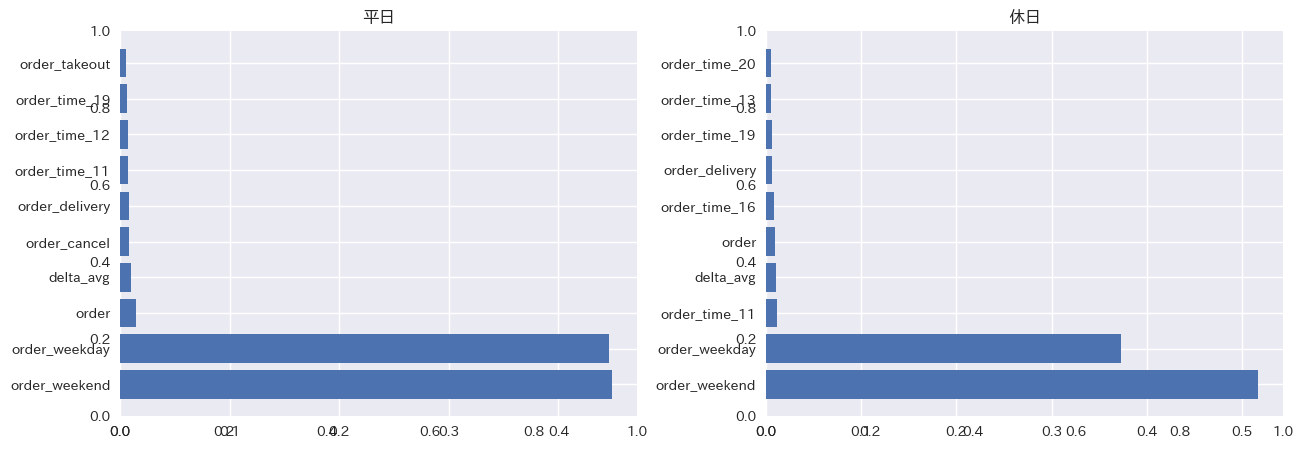

In [ ]:
# 変数重要度分析ダッシュボード

opt1 = ""
opt2 = ""

def s1_update(val):
    """"""
    global opt1
    opt1 = val["new"]
    if opt2 != "":
        graph_by_multi()

def s2_update(val):
    """"""
    global opt2
    opt2 = val["new"]
    if opt1 != "":
        graph_by_multi()

def graph_by_multi():
    """"""
    clear_output()
    display(select1, select2)

    importance_tg_wd = importance_all.loc[
        (importance_all["model_name"] == opt1) & \
        (importance_all["year_month"] == opt2) & \
        (importance_all["model_target"] == "y_weekday")
    ].copy()

    importance_tg_we = importance_all.loc[
        (importance_all["model_name"] == opt1) & \
        (importance_all["year_month"] == opt2) & \
        (importance_all["model_target"] == "y_weekend")
    ].copy()

    importance_tg_wd.sort_values("importance", ascending=False, inplace=True)
    importance_tg_we.sort_values("importance", ascending=False, inplace=True)

    importance_tg_wd = importance_tg_wd.head(10)
    importance_tg_we = importance_tg_we.head(10)

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
    plt.subplots_adjust(wspace=0.25, hspace=0.6)

    ax1 = fig.add_subplot(1, 2, 1)
    plt.barh(importance_tg_wd["cols"], importance_tg_wd["importance"])
    ax1.set_title("平日")
    
    ax2 = fig.add_subplot(1, 2, 2)
    plt.barh(importance_tg_we["cols"], importance_tg_we["importance"])
    ax2.set_title("休日")

s1_option = importance_all["model_name"].unique()
s2_option = importance_all["year_month"].unique()

select1 = Select(options=s1_option)
select1.observe(s1_update, names="value")

select2 = Select(options=s2_option)
select2.observe(s2_update, names="value")

display(select1, select2)
